# Notebook 07: Robustness Checks (Propensity Score Matching)

**Objective:**
1. **Propensity Score Matching (PSM):** Re-run the analysis on a subsample of Treated/Control firms matched strictly on fundamentals (Size, ROA, etc.).
2. **Alternative Specifications:** Verify that results hold even when we vary the control set.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from linearmodels.panel import PanelOLS
from linearmodels.panel.model import MissingValueWarning

import warnings
warnings.filterwarnings('ignore', category=MissingValueWarning)

In [44]:
file_path = 'data/final_regression_panel.csv'
df = pd.read_csv(file_path)

In [45]:
# ensure proper types
df['Month_ID'] = pd.to_datetime(df['Month_ID'])
df['Shock_Date'] = pd.to_datetime(df['Shock_Date'])

# create panel ID
df['Panel_ID'] = df['CUSIP'] + "-" + df['Event_ID'].astype(str)
df = df.set_index(['Panel_ID', 'Month_ID'])

# define controls
controls = ['Size', 'ROA', 'Leverage', 'MTB', 'Opaqueness']
df = df.dropna(subset=controls + ['Treated'])

print(f"Data Loaded: {len(df)} observations")

Data Loaded: 46662 observations


## Propensity Score Estimation
We calculate the probability of being treated based on firm fundamentals *before* the shock.

In [46]:
# take the average of controls in the pre-period
df_pre = df[df['Post'] == 0].groupby('Panel_ID')[controls + ['Treated']].mean()
df_pre = df_pre.dropna()

In [47]:
# fit logistic regression
# Treated ~ Size + ROA + Leverage + MTB + Opaqueness
logit = LogisticRegression(solver='liblinear')
logit.fit(df_pre[controls], df_pre['Treated'])
df_pre['Propensity_Score'] = logit.predict_proba(df_pre[controls])[:, 1]

## Nearest Neighbor Matching
We find the best Control match for every Treated firm based on the Propensity Score.

In [48]:
treated_firms = df_pre[df_pre['Treated'] == 1]
control_firms = df_pre[df_pre['Treated'] == 0]

# fit NN on Control firms
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_firms[['Propensity_Score']])

# find matches for Treated firms
distances, indices = nbrs.kneighbors(treated_firms[['Propensity_Score']])

# get the matched Control IDs
matched_control_indices = control_firms.iloc[indices.flatten()].index
matched_treated_indices = treated_firms.index

# combine into a "Matched Universe" list
matched_universe_ids = np.concatenate([matched_treated_indices, matched_control_indices])

print(f"Treated Firms: {len(treated_firms)}")
print(f"Matched Controls Found: {len(matched_control_indices)}")

Treated Firms: 1785
Matched Controls Found: 1785


## Visualizing Balance
Check if the matching worked. The distribution of Propensity Scores should overlap perfectly.

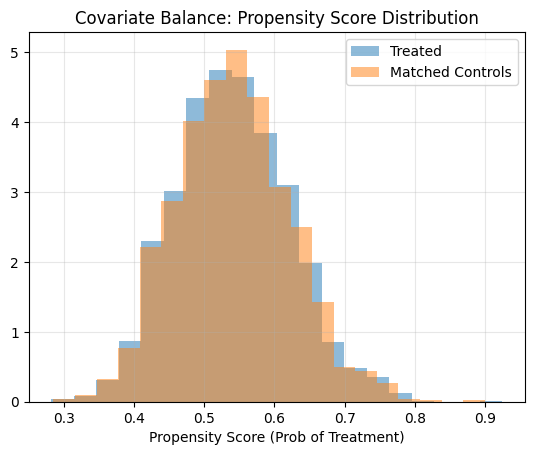

In [49]:
plt.hist(treated_firms['Propensity_Score'], alpha=0.5, label='Treated', bins=20, density=True)
plt.hist(control_firms.loc[matched_control_indices, 'Propensity_Score'], alpha=0.5, label='Matched Controls', bins=20, density=True)
plt.title('Covariate Balance: Propensity Score Distribution')
plt.xlabel('Propensity Score (Prob of Treatment)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/psm_balance.png')
plt.show()

## Re-Run Analysis on Matched Sample
Now we filter the original panel to include *only* these matched firms and re-run the IV regression.

In [50]:
# filter main dataframe to keep only matched IDs
df_matched = df[df.index.get_level_values('Panel_ID').isin(matched_universe_ids)].copy()

print(f"Original Observations: {len(df)}")
print(f"Matched Sample Observations: {len(df_matched)}")

Original Observations: 46662
Matched Sample Observations: 33383


In [51]:
def run_iv_robustness(outcome_var, data):
    # manual 2SLS on matched data
    fe_formula = 'EntityEffects + TimeEffects'
    control_formula = ' + '.join(controls)

    # stage 1
    form_s1 = f"Coverage ~ Treated_Post + {control_formula} + {fe_formula}"
    res_s1 = PanelOLS.from_formula(form_s1, data=data).fit(cov_type='clustered', cluster_entity=True)

    data['Coverage_Hat'] = res_s1.fitted_values

    # stage 2
    form_s2 = f"{outcome_var} ~ Coverage_Hat + {control_formula} + {fe_formula}"
    res_s2 = PanelOLS.from_formula(form_s2, data=data).fit(cov_type='clustered', cluster_entity=True)

    return res_s2.params['Coverage_Hat'], res_s2.tstats['Coverage_Hat']

In [52]:
# fun for all outcomes
outcomes = [
    'Price_Delay',                  # Efficiency
    'Avg_Spread', 'Avg_Amihud', 'Avg_Turnover',  # Liquidity
    'NCSKEW', 'DUVOL', 'Volatility' # Risk
]
robust_results = []

for out in outcomes:
    beta, t_stat = run_iv_robustness(out, df_matched)
    robust_results.append({
        'Outcome': out,
        'Matched_IV_Coef': beta,
        'Matched_t_stat': t_stat
    })

In [53]:
df_robust = pd.DataFrame(robust_results)
print("\n=== Robustness Results (PSM Matched Sample) ===")
print(df_robust)
df_robust.to_csv('data/robustness_psm_results.csv', index=False)


=== Robustness Results (PSM Matched Sample) ===
        Outcome  Matched_IV_Coef  Matched_t_stat
0   Price_Delay        -0.042356       -2.740494
1    Avg_Spread        -0.000303       -1.819424
2    Avg_Amihud        -0.236713       -1.004753
3  Avg_Turnover         0.275397        0.466178
4        NCSKEW        -0.048483       -1.061078
5         DUVOL        -0.034977       -0.834390
6    Volatility        -0.007850       -0.574502
